In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer
from sklearn.metrics import make_scorer
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
import time
import sys, os
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV
import skopt.space.space
from sklearn.model_selection import KFold


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")





INPUT DATA

In [56]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [57]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [58]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


PLS NRMSEPiqr

In [59]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


trials = 100
ranndom_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials)

ripartitions = [0.25, 0.50, 0.75]

results = []  

for ripartition in ripartitions:
        
    run_name = str(ripartition) + " ripartition"
    print(run_name)
    for i in range(trials):
        result = {"Ripartition":None,
                   "Trial":None,
                         "n_components_bayesian":None,
                           #"n_components_evolutionary":None,
                             "bayesian_time":None,
                             #"evolutionary_time" :None,
                             "NRMSEPiqr_bayesian":None,
                              #"NRMSEPiqr_evolutionary":None,
                               "seed": None}
            

        print("Trial:",i+1)
                
        result["Ripartition"] = ripartition
        result["Trial"] = i +1  
        result["seed"] = seeds[i]
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
        param_grid = {'pls__n_components': Integer(2,530,random_state=42),'pls_max_iter': Integer(100, 500)}  
        pls =  make_pipeline(StandardScaler(),PLSRegression())
        
        kf = KFold(n_splits=5, shuffle=True,random_state=ranndom_cv)
        #sturges = int(1 + np.log(len(X_train)))    
        '''       
        evolved_estimator = GASearchCV(estimator=pls,
                                cv=kf,
                                scoring=NRMSEPiqrscorer,
                                param_grid=param_grid,
                                n_jobs=-1,
                                verbose=False,
                                population_size=10,
                                generations=10)  
        '''
        
        bayesian_estimator = BayesSearchCV(
                                pls,
                                {'plsregression__n_components':skopt.space.space.Integer(1,100)},
                                cv=kf,
                                scoring=NRMSEPiqrscorer,
                                n_jobs=-1,
                                verbose= False,
                                 n_iter=15 )
        '''    
        start_time = time.time()
        evolved_estimator.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds

        result["evolutionary_time"] = elapsed_time
        result["n_components_evolutionary"] = float(evolved_estimator.best_params_["n_components"])
       '''
        start_time = time.time()
        bayesian_estimator.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds

        result["bayesian_time"] = elapsed_time
        result["n_components_bayesian"] = float(bayesian_estimator.best_params_["plsregression__n_components"])
    
           
        #result["NRMSEPiqr_evolutionary"] = NRMSEPiqr(Y_test, evolved_estimator.predict(X_test))
    

        result["NRMSEPiqr_bayesian"] =  NRMSEPiqr(Y_test,bayesian_estimator.predict(X_test))
    
        print(result)
        results.append(result)

0.25 ripartition
Trial: 1
{'Ripartition': 0.25, 'Trial': 1, 'n_components_bayesian': 57.0, 'bayesian_time': 11.16701340675354, 'NRMSEPiqr_bayesian': 0.3416690153333917, 'seed': 47}
Trial: 2
{'Ripartition': 0.25, 'Trial': 2, 'n_components_bayesian': 66.0, 'bayesian_time': 8.427505493164062, 'NRMSEPiqr_bayesian': 0.296816193189811, 'seed': 59}
Trial: 3


KeyboardInterrupt: 

In [49]:


df = pd.DataFrame(results)
df.to_excel("PLS_Bayes.xlsx")



In [50]:
from collections import Counter

pls_components = {ripartitions[0]:0,ripartitions[1]:0,ripartitions[2]:0}

#Compute the mean for every ripartition
for trial in results:
    pls_components[trial["Ripartition"]]+=trial["n_components_bayesian"]/trials



print("Average values:",pls_components)



Average values: {0.25: 57.839999999999996, 0.5: 55.33, 0.75: 40.86999999999998}
Most common values: [(62.0, 8), (56.0, 7), (53.0, 7), (61.0, 7), (67.0, 5), (63.0, 5), (55.0, 5), (52.0, 5), (51.0, 4), (50.0, 4), (48.0, 4), (59.0, 4), (49.0, 4), (66.0, 3), (57.0, 3), (65.0, 3), (54.0, 3), (70.0, 3), (64.0, 3), (42.0, 2), (58.0, 2), (45.0, 2), (69.0, 1), (72.0, 1), (60.0, 1), (73.0, 1), (41.0, 1), (74.0, 1), (78.0, 1)]
Most common values: [(56.0, 7), (61.0, 7), (54.0, 6), (57.0, 6), (52.0, 5), (63.0, 5), (55.0, 5), (59.0, 5), (46.0, 4), (58.0, 4), (62.0, 4), (51.0, 4), (53.0, 4), (64.0, 4), (44.0, 3), (41.0, 3), (65.0, 2), (49.0, 2), (45.0, 2), (50.0, 2), (43.0, 2), (70.0, 2), (60.0, 2), (72.0, 2), (68.0, 1), (32.0, 1), (48.0, 1), (66.0, 1), (34.0, 1), (69.0, 1), (40.0, 1), (47.0, 1)]
Most common values: [(32.0, 6), (41.0, 5), (49.0, 5), (31.0, 5), (36.0, 5), (53.0, 4), (46.0, 4), (39.0, 4), (42.0, 3), (57.0, 3), (60.0, 3), (28.0, 3), (52.0, 3), (38.0, 3), (24.0, 3), (51.0, 3), (37.0, 3),

PLS NRMSEPiqr best components

╔════════════════╦══════════════════╦═════════════════╦════════════════════════════╦════════════════╗
║   Test size(%) ║   Mean NRMSEPiqr ║   Var NRMSEPiqr ║   Mean Training Time (sec) ║   N_components ║
╠════════════════╬══════════════════╬═════════════════╬════════════════════════════╬════════════════╣
║             25 ║         0.297868 ║     0.000324154 ║                   0.852258 ║             58 ║
╚════════════════╩══════════════════╩═════════════════╩════════════════════════════╩════════════════╝


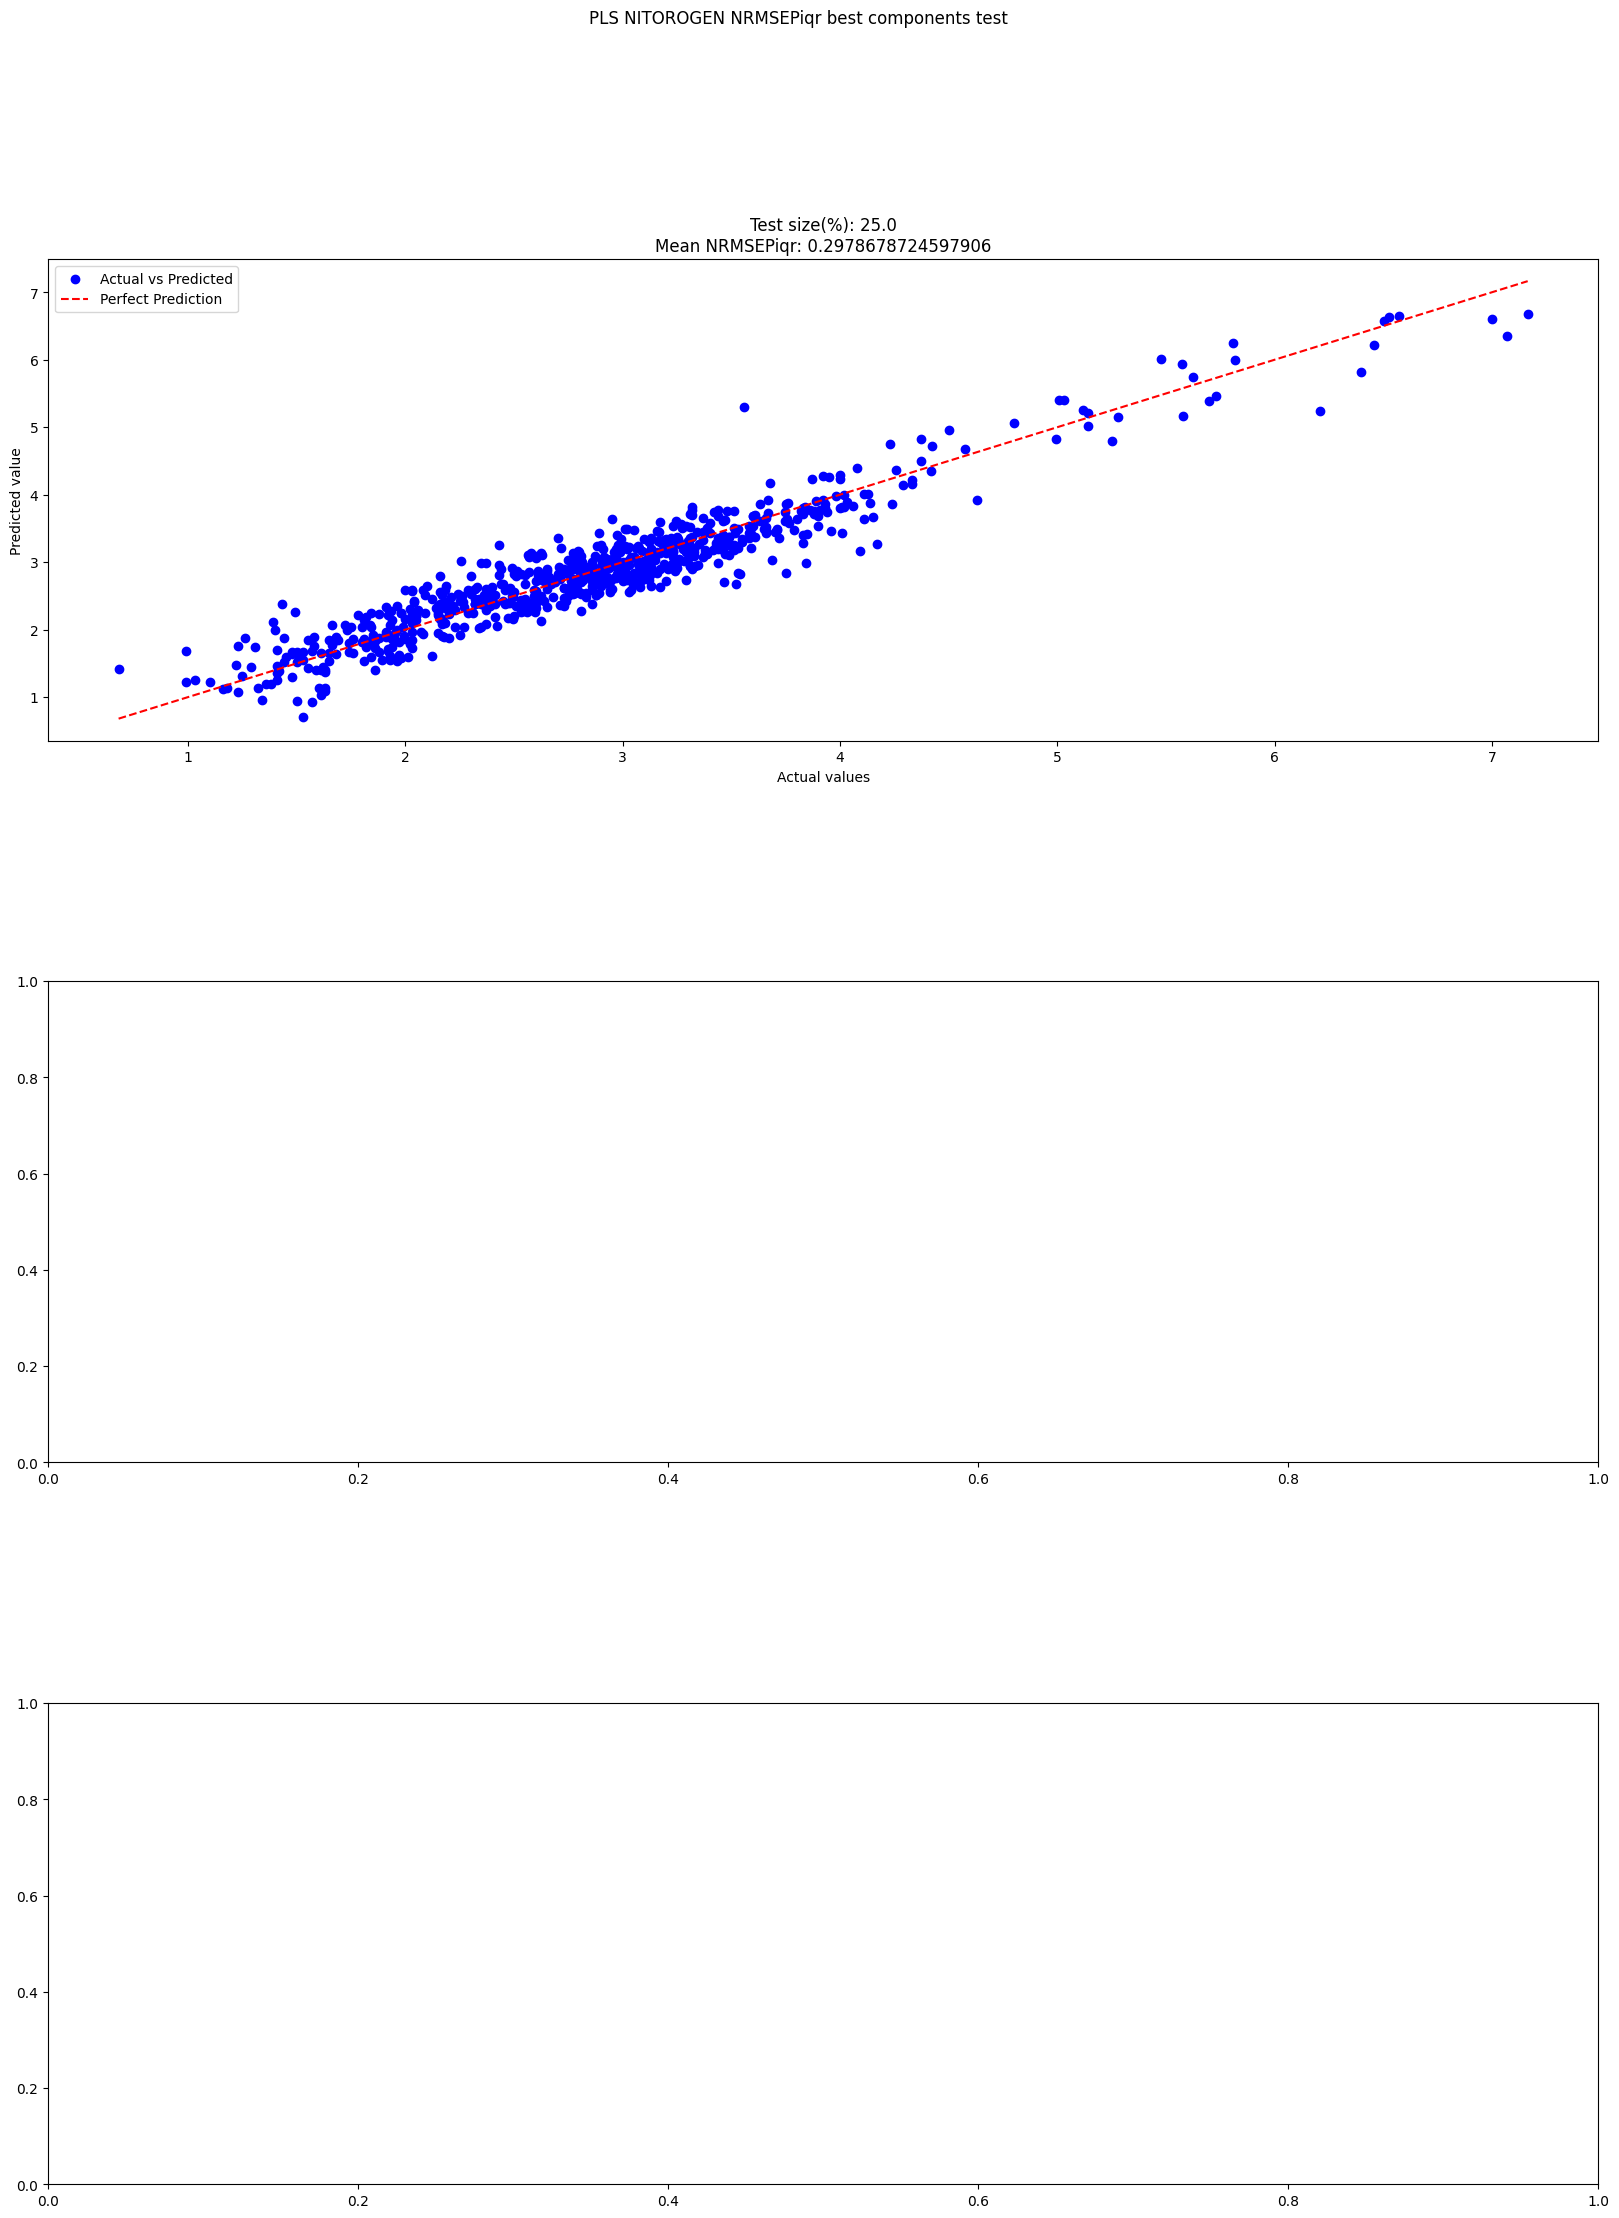

In [54]:


# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle(f'PLS NITOROGEN NRMSEPiqr best components test' + "\n")
axs = axs.flatten()
k = 0

trials = 100
random_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials)


results = []

for n_components, ripartition in zip (pls_components.values(),ripartitions):
    
    NRMSE = []
    total_time = 0
    for i in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
        pls_model = make_pipeline(StandardScaler(),PLSRegression(n_components=n_components))
            
        start_time = time.time()
        pls_model.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds
        
        # Make predictions using the testing set
        Y_pred_pls = pls_model.predict(X_test)

        
        NRMSE.append(NRMSEPiqr(Y_test, Y_pred_pls))
        total_time+=elapsed_time
        

    results.append([str(ripartition *100 ),np.mean(NRMSE), np.var(NRMSE),
                       total_time/trials, n_components ])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(Y_test,Y_pred_pls, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                            [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" + "\n" + "Mean NRMSEPiqr: " + str(results[k][1]) )
    k += 1

    '''SHOW RESULTS'''

headers = ["Test size(%)", "Mean NRMSEPiqr", "Var NRMSEPiqr","Mean Training Time (sec)" ,"N_components"]
print(tabulate(results, headers,  tablefmt="double_outline"))


In [8]:
# Extract latent variables (scores)
X_latent = pls_model.x_scores_  # Latent variables for predictors
Y_latent = pls_model.y_scores_  # Latent variables for target

print(X_latent.shape)  # Should output (726, n_components)
print(Y_latent.shape)  # Should output (726, 1) if it's a single target variable

# Convert to DataFrames for easier inspection
X_latent_df = pd.DataFrame(X_latent, columns=[f'Latent Variable {i+1}' for i in range(n_components)])
Y_latent_df = pd.DataFrame(Y_latent, columns=['Latent Variable Y'])

# Display the latent variables
print("Latent Variables for X:\n", X_latent_df.head())
print("Latent Variables for Y:\n", Y_latent_df.head())

(726, 50)
(726, 50)


ValueError: Shape of passed values is (726, 50), indices imply (726, 1)